# Modeling of the store's sales through their surroundings.
## Author: Gregorio Ferreira - ferreiradesajg@gmail.com

### Document description:
This notebook contains the steps followed to pre-process and extract the target variables to train the models considering the sales history of each of the stores under consideration.

In [1]:
## Loading prepared data and necessary environment
import pandas as pd
from sklearn.model_selection import train_test_split
import os
os.chdir('XXX - YOUR PATH HERE - XXX')

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

sales = pd.read_csv("C:/Users/jgfer/Google Drive/PMI/UseCase_3_Datasets/result dataset/stores_sales.csv",
                     index_col = 0)

#['count_non_na', 'trim_mean_01', 'trim_mean_02', 'mean', 'min', 'max',
#       'count_non_na_class', 'trim_mean_01_class', 'trim_mean_02_class',
#       'mean_class', 'min_class', 'max_class']

sales = pd.read_csv("./result dataset/stores_sales.csv", index_col=0)

## The idea is to demonstrate the workflow, techniques, and steps to analyze the data, rather than to focus on the optimization and best performance. Two different analyses are provided, these are believed, could be easily re-used and that offer the opportunity to deep-dive later on:

### 1. Regression approach: fitting the features to the 'trim_mean_01' target variable:



In [2]:
target = sales[['trim_mean_01']]
target.columns = ['target']

## loading my surroundings
my_surr = pd.read_csv("./result dataset/surroundings_count.csv",
                      index_col = 0)

## merging features and targets
mydata = pd.merge(my_surr, target,  how='inner', left_index=True, right_index=True)

Y = mydata['target']
X = mydata.drop('target', axis = 1)


In [3]:
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from minepy import MINE
from sklearn.model_selection import GridSearchCV
 
np.random.seed(0)
 
names = X.columns
 
ranks = {}
# Function to scale the importante of each feature, so it is possible to compare it between different models
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

In [4]:
## Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)

df = pd.DataFrame()
df["Linear reg"] = ranks["Linear reg"].values()
df.index = ranks["Linear reg"].keys()

## Ridge
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)

temp = pd.DataFrame()
temp["Ridge"] = ranks["Ridge"].values()
temp.index = ranks["Ridge"].keys()

df = pd.merge(df, temp,  how='left', left_index=True, right_index=True)

## Lasso
### Searching for the optimal alpha
lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, Y)
clf.best_params_ # alpha=0.31622776601683794

lasso = Lasso(alpha=0.31622776601683794)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)

temp = pd.DataFrame()
temp["Lasso"] = ranks["Lasso"].values()
temp.index = ranks["Lasso"].keys()

df = pd.merge(df, temp,  how='left', left_index=True, right_index=True)

## RandomizedLasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)

temp = pd.DataFrame()
temp["Stability"] = ranks["Stability"].values()
temp.index = ranks["Stability"].keys()

df = pd.merge(df, temp,  how='left', left_index=True, right_index=True)

## Recurseive feature elimination
rfe = RFE(lr, n_features_to_select=8)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(np.abs(rfe.ranking_), names, order=-1)

temp = pd.DataFrame()
temp["RFE"] = ranks["RFE"].values()
temp.index = ranks["RFE"].keys()

df = pd.merge(df, temp,  how='left', left_index=True, right_index=True)

## RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

temp = pd.DataFrame()
temp["RF"] = ranks["RF"].values()
temp.index = ranks["RF"].keys()

df = pd.merge(df, temp,  how='left', left_index=True, right_index=True)

## f_regression
f, pval = f_regression(X, Y, center=True)
f = np.nan_to_num(f)
ranks["Corr."] = rank_to_dict(f, names)

temp = pd.DataFrame()
temp["Corr."] = ranks["Corr."].values()
temp.index = ranks["Corr."].keys()

df = pd.merge(df, temp,  how='left', left_index=True, right_index=True)

## maximal information-based nonparametric exploration
mine = MINE()
mic_scores = []
for i in range(X.shape[1]):
    mine.compute_score(X.values[:,i], Y)
    m = mine.mic()
    mic_scores.append(m)
 
ranks["MIC"] = rank_to_dict(mic_scores, names) 

temp = pd.DataFrame()
temp["MIC"] = ranks["MIC"].values()
temp.index = ranks["MIC"].keys()

df = pd.merge(df, temp,  how='left', left_index=True, right_index=True)
 
df['mean'] = df.mean(axis=1)
df['median'] = df.median(axis=1)

df.to_csv("./result dataset/VarImp_trim_mean_01.csv",
                          sep=',', encoding='utf-8', index=True)

In [5]:
df.sort_values('mean', ascending=False).head(n = 10)

,Linear reg,Ridge,Lasso,Stability,RFE,RF,Corr.,MIC,mean,median
subway_station,0.93,1.00,0.94,0.99,1.00,0.02,1.00,0.42,0.78750,0.94000
amusement_park,1.00,0.89,1.00,0.99,1.00,0.36,0.13,0.13,0.68750,0.89000
car_rental,0.19,0.34,0.19,1.00,0.87,0.88,0.41,0.65,0.56625,0.56625
department_store,0.24,0.47,0.25,1.00,1.00,0.12,0.34,0.82,0.53000,0.47000
airport,0.78,0.38,0.76,0.97,0.95,0.00,0.00,0.18,0.50250,0.50250
post_office,0.21,0.38,0.21,1.00,1.00,0.01,0.33,0.67,0.47625,0.38000
roofing_contractor,0.37,0.48,0.37,0.97,1.00,0.00,0.02,0.52,0.46625,0.46625
pharmacy,0.05,0.10,0.05,0.94,0.78,0.09,0.69,1.00,0.46250,0.46250
movie_rental,0.73,0.38,0.71,0.90,0.81,0.00,0.00,0.09,0.45250,0.45250
library,0.10,0.25,0.10,1.00,0.94,0.01,0.44,0.75,0.44875,0.44000


### Conclusions from the Regression approach:
A simplistic, yet informative, workflow was demonstrated. Step by step, the importance of each of the feature was calculated for eight different approaches.

The results obtained, when training the model with a trained dataset and validated against a test data set, are of low information. The accuracy achieved is below 30%.

________________________________________________________________________________________________________________________________

### 2. Classification approach
As demonstrated during the sales data preparation, for each of the target variables, the Quantiles with probabilities 0.2/0.4/0.6/0.8 were calculated and used two classify each of the target variables into the bottom/low/standard/high/top Class

In [6]:
import pandas as pd
import numpy as np
from sklearn.base import clone
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Code for Sequential Backward Selection(SBS)
## Taken from: # http://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Preprocessing-III-Dimensionality-reduction-via-Sequential-feature-selection-Assessing-feature-importance-via-random-forests.php

class SBS():
    def __init__(self, estimator, k_features,
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
        random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
        X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
        
    def _calc_score(self, X_train, y_train,
                        X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [7]:
## Trget variable
target = sales[['trim_mean_01_class']]
target.columns = ['target']


## merging features and targets
mydata = pd.merge(my_surr, target,  how='inner', left_index=True, right_index=True)

Y = mydata['target']
X = mydata.drop('target', axis = 1)

## Data split and normalization

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify= Y, test_size=0.2, random_state = 2311)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

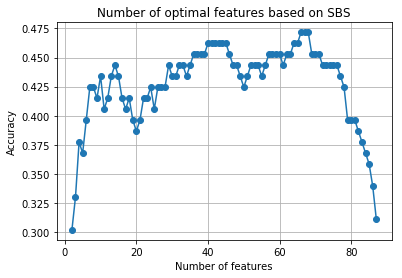

In [9]:
## Evaluating the number of optimals features as propossed by the author of the SBS funciton
from sklearn.neighbors import KNeighborsClassifier

# sqrt(424)/2 Out[16]: 10.295630140987001

knn = KNeighborsClassifier(n_neighbors=10)
sbs = SBS(knn, k_features=2)
sbs.fit(X_train, y_train)

from matplotlib import *
import sys
from pylab import *

k_feat = [len(k) for k in sbs.subsets_]

plot(k_feat, sbs.scores_, marker='o')
ylabel('Accuracy')
xlabel('Number of features')
title('Number of optimal features based on SBS')
grid()

show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Grid defined to tune RandomForestClassifier
my_grid = []
rf_tuned_parameters = [{"n_estimators": [5, 10, 20, 30, 40, 50, 60]}]
my_grid.append(["RandomForest", RandomForestClassifier(n_jobs=-1), rf_tuned_parameters])        

for name, model, parameters in my_grid:

    clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", verbose=5, n_jobs=4)
    clf.fit(X_train, y_train)
    best_estimator = clf.best_estimator_
    print([str(clf.best_params_), clf.best_score_, best_estimator])
    
best_estimator.fit(X_train, y_train)

np.random.seed(0)
names = X.columns
 
ranks = {}
from sklearn.preprocessing import MinMaxScaler

def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))



ranks["rf"] = rank_to_dict(best_estimator.feature_importances_, names)

df = pd.DataFrame()
df["rf"] = ranks["rf"].values()
df.index = ranks["rf"].keys()

df.to_csv("./result dataset/VarImp_trim_mean_01_class.csv",
                          sep=',', encoding='utf-8', index=True)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    5.9s finished


["{'n_estimators': 40}", 0.37735849056603776, RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)]


In [11]:
## VarImpo from RandomForestClassifier

df.sort_values('rf', ascending=False).head(n = 10)

,rf
store,1.00
doctor,0.83
restaurant,0.75
real_estate_agency,0.73
electronics_store,0.71
dentist,0.64
beauty_salon,0.63
hair_care,0.63
transit_station,0.63
bus_station,0.62


### Conclusions from the Regression approach:
The results obtained by considering the five calculated classes doesn't seem correct based on the assumption of the expected smoking patterns.
Let's calculate the confusion matrix, so it is possible to understand how the classes are being evaluated.

Normalized confusion matrix
[[ 0.58  0.09  0.21  0.09  0.03]
 [ 0.27  0.2   0.13  0.27  0.13]
 [ 0.68  0.12  0.12  0.08  0.  ]
 [ 0.5   0.09  0.14  0.23  0.05]
 [ 0.27  0.    0.27  0.27  0.18]]


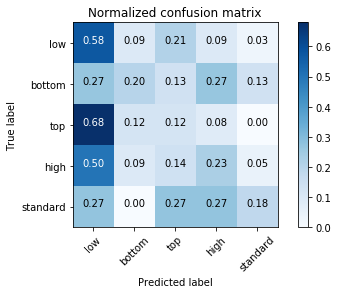

In [12]:
## From sklearn examples: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

y_pred = best_estimator.predict(X_test)

class_names = Y.unique()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['bottom', 'low', 'standard', 'high', 'top'],
                      # title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Thanks to the existing [Confusion Matrix example in sklearn][1] it is possible to see that only the "low" Class was classified with an accuracy above 60%.

One explanation could be that the amount of samples for this class is higher than the other. Even when the quantiles approach used to calculate each class keeps them balanced, due to the missing stores (available in the sales data and not in the features) the classes are no longer balanced as shown in the above table.

It is possible to repeat the exercise, and filter those stores code not available in the Surrounding data so that the calculated classes will remain balanced. It is expected that the model accuracy increase.




[1]:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [13]:
class_freq = mydata.groupby(['target'])['target'].agg(['count'])

class_freq['pct'] = 100*(class_freq / class_freq['count'].sum())

class_freq

,count,pct
target,,
bottom,165,31.132075
high,75,14.150943
low,126,23.773585
standard,110,20.754717
top,54,10.188679
